In [1]:
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration
import requests
from PIL import Image
import torch
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Pix2StructProcessor.from_pretrained('google/matcha-chartqa')
model = Pix2StructForConditionalGeneration.from_pretrained('google/matcha-chartqa').to(device)

from datasets import load_dataset
import pandas as pd



dataset = load_dataset('eduvedras/QA', trust_remote_code=True)

/home/eduvedras/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eduvedras/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


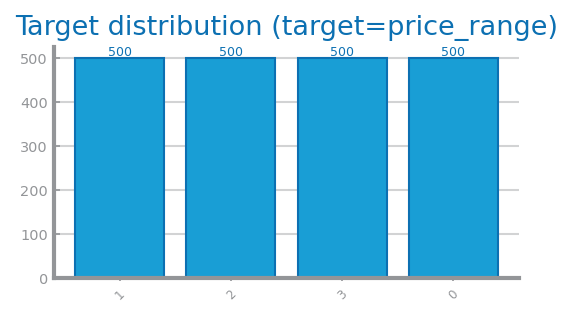

In [3]:
dataset['test'][56]['Chart']

In [13]:
from tqdm.auto import tqdm

predictions = []
references = []

for i in tqdm(range(len(dataset))):
    inputs = processor(images=dataset[i]['Chart'], text= dataset[i]['Question'],return_tensors="pt").to(device)
    answer_tensor = model.generate(**inputs, max_new_tokens=5)
    answer = processor.decode(answer_tensor[0], skip_special_tokens=True)
    predictions.append(answer)
    references.append(dataset[i]['Answer'])
    

100%|██████████| 57/57 [00:42<00:00,  1.35it/s]


In [7]:
inputs = processor(images=dataset['test'][56]['Chart'], text= "What is the target?",return_tensors="pt").to(device)
answer_tensor = model.generate(**inputs, max_new_tokens=500)
answer = processor.decode(answer_tensor[0], skip_special_tokens=True)
print(answer)

500


In [7]:
import pandas as pd

new_df = pd.DataFrame(columns=['Image','Prediction'])

i=0
while i < len(dataset):
    if ((new_df['Image'] == dataset[i]['Chart_name']) & (new_df['Prediction'] == predictions[i])).any():
        i += 1
        continue
    else:
        new_df.loc[len(new_df)] = {'Image': dataset[i]['Chart_name'], 'Prediction': predictions[i]}
        i += 1
    
new_df.to_csv(f'predictions-notraining.csv', index=False)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.